# Weight fee calculations

## Functionality

The main goal of this notebook is to be able to calculate the prices for different extrinsics given:
* Weight coefficient: The coefficient that is used to calculate the token fee of an extrinsic given its weight
* Length coefficient: The coefficient that is used to calculate the token fee of an extrinsic given its length
* Max Market Cap: An estimation of the maximum possible initial market cap of the chain
* Min Market Cap: An estimation of the minimum possible initial market cap of the chain
* Issuance: The initial number of tokens in the chain

We also define an **Attack Cost** the attack cost is just a measure of how much would it cost in cents to fully occupy every block for 24hrs.

The formula used to calculate the token fee is:
```
fee = (extrinsic_weight + BASE_WEIGHT) * weight_coefficient + length_fee * fee_coefficient
```
(With the caveat of parameters and length assumed to be 0, explained further below)

To calculate the price:
```
price = (MARKET_CAP / ISSUANCE) * fee 
```

To calculate the **Attack Cost**:
```
attack_cost = (SECONDS_IN_DAY / BLOCK_DURATION(seconds) * MAX_BLOCK_LEGTH) * fee_coefficient
```

## How to use

After running all cells in this notebook you will be presented with a dashboard.

This dashboard has a table with the minimum price and maximum price for extrinsics for a given min and max market cap respectively.

To chose what extrinsics are displayed modify the array `DISPLAY_EXTRINSICS` here(leave it empty to display every extrinsinc):

**Note: that the extrinsic name is actually `<pallet_name>::<benchmark_function>`**

In [1]:
RUNTIME_UPGRADE = "pallet_codex::runtime_upgrade"
MIN_EXTRINSIC = "min_extrinsic"

# This is an array of extrinsics to display if it is empty all extrinsics are displayed
DISPLAY_EXTRINSICS = [
    "pallet_balances::transfer", 
    RUNTIME_UPGRADE, 
    "working_group::add_worker", 
    "referendum::vote", 
    "proposals_discussion::add_post",
    MIN_EXTRINSIC
]

The extrinsic displayed in the dashboard by default are assumed to have a length of 0 and all the parameters set to 0.

To change this you can set the `LENGTHS` dictionary here with key `<extrinsic>` and value `<length_value>`

In [2]:
# Length is a dictionary with the lengths for the functions
# if the length for a given extrinsic is not given 0 will be assumed
LENGTHS = {
    RUNTIME_UPGRADE: 3_000_000
}

To set a value for a specific parameter use the `PARAMS` dictionary.

each key is an `<extrinsic>` name and the value is a dictionary with `<param>: value`

In [3]:
# A dictionary with parameters for a given extrinsic if it's not given assumes 0
# Note: if any param is provided all params must be provided
PARAMS = {
    "proposals_discussion::add_post": {
        'i': 3_000,
    }
}

Furthermore after the dashboard there is a dedicated section to customize the parameters/length for specific extrinsics that are worth looking at sparately.

### Importing relevant modules

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import *
import numpy as np
from math import ceil
from scipy import optimize
import pandas as pd
%matplotlib notebook

### Parsing weight files

This section parses the weight files in weights/ to have a dictionary with all possible extrinsic weight

The dictionary have the following format

```
{
    extrinsic_name: {
        "base_weight": base_weight,
        "db_reads": {
            "base": base_weight,
            "vars": [db_vars]
        },
        "db_writes": {
            "base": base_weight,
            "vars": [db_vars]
        },
        "vars": vars
    }
}
```

**Note:** the parsing is very specific for the generated weight files, this is very brittle. A future upgrade could be to use some kind of rust parser. 

In [5]:
import re
from os import listdir

import pathlib
WEIGHTS_DIR = pathlib.Path().absolute().parent / 'runtime' / 'src' / 'weights'

BASE_WEIGHT = "base_weight"
DB_READS = "db_reads"
DB_WRITES = "db_writes"
BASE_DB = "base"
DB_VARS = "vars"
TRANSFER = "pallet_balances::transfer"
VARS = "vars"

match_parenthesis = r'\(.*'
match_base_weight = r'\(((\d+_{0,1})+)'
re_match_base_weight = re.compile(match_base_weight)
match_db_ops_reads = r'DbWeight::get\(\).reads\((\d+) as Weight\)'
match_db_ops_writes = r'DbWeight::get\(\).writes\((\d+) as Weight\)'
re_match_db_ops_reads = re.compile(match_db_ops_reads)
re_match_db_ops_writes = re.compile(match_db_ops_writes)
match_scaling_var = r'\((\D) as Weight\)'
re_match_scaling_var = re.compile(match_scaling_var)

weights = {}
for file_name in listdir(WEIGHTS_DIR):
    with open(WEIGHTS_DIR / file_name) as f:
        start_reading = False
        reading_func = False
        function_name = ""
        weight = 0
        db_reads_base = 0
        db_reads = []
        db_writes_base = 0
        db_writes = []
        variables = []
        pallet_name = ""
        for line in f:
            words = line.strip().split(" ")
            if words[0] == "impl":
                start_reading = True
                pallet_name = words[1].split("::")[0]

            if reading_func:
                if reading_func and "}" in words:
                    reading_func = False
                    weights[function_name] = {
                        BASE_WEIGHT: weight,
                        DB_READS: {
                            BASE_DB: db_reads_base,
                            DB_VARS: db_reads
                        },
                        DB_WRITES: {
                            BASE_DB: db_writes_base,
                            DB_VARS: db_writes,
                        },
                        VARS: variables
                    }
                    weight = 0
                    db_reads_base = 0
                    db_writes_base = 0
                    variables = []
                    db_reads = []
                    db_writes = []

                if "DbWeight::get()" in line:
                    if "reads" in line:
                        if re.search(re_match_scaling_var, line):
                            var = re.search(
                                re_match_scaling_var, line).group(1)
                            weight_factor = re.search(
                                re_match_base_weight, line).group(1)
                            db_reads.append((var, int(weight_factor)))
                        else:
                            db_reads_base = int(
                                re.search(re_match_db_ops_reads, line).group(1))

                    if "writes" in line:
                        if re.search(re_match_scaling_var, line):
                            var = re.search(
                                re_match_scaling_var, line).group(1)
                            weight_factor = re.search(
                                re_match_base_weight, line).group(1)
                            db_writes.append((var, int(weight_factor)))
                        else:
                            db_writes_base = int(
                                re.search(re_match_db_ops_writes, line).group(1))
                else:
                    if re.match(re_match_base_weight, words[0]) is not None:
                        match = re.match(re_match_base_weight, words[0])
                        weight = int(match.group(1))

                    if re.search(re_match_scaling_var, line):
                        var = re.search(re_match_scaling_var, line).group(1)
                        weight_factor = re.search(
                            re_match_base_weight, line).group(1)
                        variables.append((var, int(weight_factor)))

            if start_reading and words[0] == "fn":
                reading_func = True
                function_name = re.sub(match_parenthesis, '', words[1])
                function_name = pallet_name + "::" + function_name

#### Additional weight dictionary configuration

In [6]:
# Constants for our runtime
WEIGHT_PER_SECOND = 1_000_000_000_000;
WEIGHT_PER_MILLIS = WEIGHT_PER_SECOND / 1000 # 1_000_000_000
WEIGHT_PER_MICROS = WEIGHT_PER_MILLIS / 1000 # 1_000_000
WEIGHT_PER_NANOS   = WEIGHT_PER_MICROS / 1000 # 1_000
MAX_BLOCK_LENGTH = 5 * 1024 * 1024
MIN_EXTRINSIC_WEIGHT = 125 * WEIGHT_PER_MILLIS
MAX_BLOCK_WEIGHT = 2 * 1_000_000_000_000


weights[RUNTIME_UPGRADE] =  {
    BASE_WEIGHT: MAX_BLOCK_WEIGHT,
    DB_READS: {
        BASE_DB: 0,
        DB_VARS: []
    },
    DB_WRITES: {
        BASE_DB: 0,
        DB_VARS: []
    },
    VARS: []
}

weights[MIN_EXTRINSIC] =  {
    BASE_WEIGHT: 0,
    DB_READS: {
        BASE_DB: 0,
        DB_VARS: []
    },
    DB_WRITES: {
        BASE_DB: 0,
        DB_VARS: []
    },
    VARS: []
}


### Constants & Defaults

In [7]:
# Weight of DB operations
WRITE_WEIGHT = 100 * 1_000_000
READ_WEIGHT = 25 * 1_000_000

# Default values 
DEFAULT_ISSUANCE = 250_000_000
DEFAULT_MIN_MARKET_CAP = 50 * 100 * 250 # cents
DEFAULT_MAX_MARKET_CAP = 100 * 1_000_000_000

# Constants for our runtime
BLOCK_DURATION = 6
SECONDS_IN_DAY = 24 * 60 * 60
BLOCKS_PER_DAY = SECONDS_IN_DAY / BLOCK_DURATION
EXTRINSIC_BASE_WEIGHT = 125 * WEIGHT_PER_MICROS

# The targeted saturation for a block in the demand/price function
TARGET_SATURATION = 0.25

# Extrinsic used to adjust the price/demand function
DEFAULT_TARGET_EXTRINSIC = TRANSFER

### Mapping functions

In [8]:
# Assume that weight to fee is proportional
def weight_to_fee(weight, coeff):
    return coeff * weight

def length_to_fee(length, coeff):
    return coeff * length

def token_to_price(token, market_cap, issuance):
    return (market_cap / issuance) * token

def price_to_token(price, market_cap, issuance):
    return (issuance / market_cap) * price

def fee_to_coeff(fee, length):
    return fee / length

def price_weight_function(x, weight_coefficient, market_cap, issuance): 
    return token_to_price(weight_to_fee(x, weight_coefficient), market_cap, issuance)

def price_length_function(x, length_coefficient, market_cap, issuance):
    return token_to_price(length_to_fee(x, length_coefficient), market_cap, issuance)

### Calculations

In [9]:
def print_var_err(var, extrn):
    print("WARNING: the parameter {} isn't defined in the calculation for extrinsic: {}".format(var[0], extrn))
    
def calc_vars_weight(weight, extrinsic, params):
    total = 0
    if extrinsic in params:
        for var in weight[VARS]:
            if var[0] in params[extrinsic]:
                total += params[extrinsic][var[0]] * var[1]
            else:
                print_var_err(var, extrinsic)
        for var in weight[DB_READS][DB_VARS]:
            if var[0] in params[extrinsic]:
                total += params[extrinsic][var[0]] * var[1] * READ_WEIGHT
            else:
                print_var_err(var, extrinsic)
        for var in weight[DB_WRITES][DB_VARS]:
            if var[0] in params[extrinsic]:
                total += params[extrinsic][var] * WRITE_WEIGHT
            else:
                print_var_err(var, extrinsic)
    return total

def calc_weight(weight, extrinsic, params):
    vars_weight = calc_vars_weight(weight, extrinsic, params)
    return vars_weight + \
        weight[BASE_WEIGHT] + \
        weight[DB_READS][BASE_DB] * READ_WEIGHT + \
        weight[DB_WRITES][BASE_DB] * WRITE_WEIGHT 

def calc_total_price_given_params(extrinsic, weight_coeff, market_cap, issuance, length_coeff, params, lengths):
        return price_weight_function(calc_weight(weights[extrinsic], extrinsic, params) \
                                     + EXTRINSIC_BASE_WEIGHT, weight_coeff, market_cap, issuance) + \
            price_length_function(lengths.get(extrinsic, 0), length_coeff, market_cap, issuance)
    
def calc_total_fee(extrinsic, weight_coeff, length_coeff, params, lengths):
     return weight_to_fee(calc_weight(weights[extrinsic], extrinsic, params) + EXTRINSIC_BASE_WEIGHT, weight_coeff) + \
            length_to_fee(lengths.get(extrinsic, 0), length_coeff)

def calc_total_price(extrinsic, weight_coeff, market_cap, issuance, length_coeff):
        return calc_total_price_given_params(
            extrinsic, 
            weight_coeff, 
            market_cap, 
            issuance, 
            length_coeff, 
            PARAMS, 
            LENGTHS
        )

def calc_attack_cost(length_coeff, market_cap, issuance):
    return token_to_price(
        length_to_fee(MAX_BLOCK_LENGTH, length_coeff) * BLOCKS_PER_DAY,
        market_cap,
        issuance
    )

def calc_length_coeff(attack_cost, market_cap, issuance):
    tokens = price_to_token(attack_cost, market_cap, issuance)
    tokens_per_block = tokens / BLOCKS_PER_DAY
    return fee_to_coeff(tokens_per_block, MAX_BLOCK_LENGTH)

def get_computed_values(
    extrinsic, 
    weight_model, 
    weight_coeff, 
    min_market_cap, 
    max_market_cap, 
    issuance, 
    length_coeff, 
    params, 
    lengths
):
            weight = calc_weight(weight_model, extrinsic, params)
            tokens = calc_total_fee(extrinsic, weight_coeff, length_coeff, params, lengths)
            min_price = calc_total_price_given_params(
                extrinsic, 
                weight_coeff, 
                min_market_cap, 
                issuance, 
                length_coeff, 
                params, 
                lengths
            )
            max_price = calc_total_price_given_params(
                extrinsic, 
                weight_coeff, 
                max_market_cap, 
                issuance, 
                length_coeff, 
                params, 
                lengths
            )
            return weight, tokens, min_price, max_price 

def calc_all_price(weight_coeff, issuance, length_coeff, min_market_cap, max_market_cap):
    names = []
    computed_weights = []
    computed_tokens = []
    min_prices = []
    max_prices = []
    for (key, val) in weights.items():
        if not DISPLAY_EXTRINSICS or key in DISPLAY_EXTRINSICS:
            weight, tokens, min_price, max_price = get_computed_values(
                key, 
                val, 
                weight_coeff, 
                min_market_cap, 
                max_market_cap, 
                issuance, 
                length_coeff, 
                PARAMS, 
                LENGTHS
            )
            names.append(key)
            computed_weights.append(weight)
            min_prices.append(min_price / 100) # / 100 because we convert back to dollars
            max_prices.append(max_price / 100) # / 100 because we convert back to dollars
            computed_tokens.append(tokens)
    
    weight_table = {
        "Extrinsic": names, 
        "Weight": computed_weights,
        "Tokens(JOY)": computed_tokens,
        "Min Price(US$)": min_prices,
        "Max Price(US$)": max_prices
    }
    df = pd.DataFrame(weight_table)
    
    return df, min_prices, max_prices

### Display functions

In [10]:
def show_dashboard(extrinsic_name, params, length):
    def update(
        weight_coeff,
        min_market_cap,
        max_market_cap,
        issuance, 
        length_coeff,
    ):
        params = { extrinsic_name: parameters }
        lengths = { extrinsic_name: length }
        weight, tokens, min_price, max_price = get_computed_values(
            extrinsic_name, 
            weights[extrinsic_name], 
            weight_coeff, 
            min_market_cap, 
            max_market_cap, 
            issuance, 
            length_coeff,
            params,
            lengths
        )


        weight_table = {
            "Extrinsic": [extrinsic_name], 
            "Weight": [weight],
            "Tokens(JOY)": [tokens],
            "Min Price(US$)": [min_price],
            "Max Price(US$)": [max_price],
        }

        df = pd.DataFrame(weight_table)
        display(df.style.hide_index())

    w = interactive(
        update,
        weight_coeff=weight_coeff_widget,
        min_market_cap=min_market_cap_widget,
        max_market_cap=max_market_cap_widget,
        issuance=issuance_widget, 
        length_coeff=length_coefficient_widget,
        watch_extrinsic=watch_extrinsic_widget
    )

    display(w)

### Widgets

In [11]:
weight_coeff_widget = FloatText(
    value=0.00001,
    step=0.00001,
    description='Weight Coefficient',
    disabled=False,
    layout=Layout(width='auto', max_width='500px')
)

attack_cost_widget = FloatText(
    value = calc_attack_cost(1, DEFAULT_MIN_MARKET_CAP, DEFAULT_ISSUANCE),
    description="Attack cost(¢)",
)

min_market_cap_widget = IntText(
    value=DEFAULT_MIN_MARKET_CAP,
    description='Min Market Cap(¢)',
    disabled=False,
    layout=Layout(width='auto', max_width='500px')
)

max_market_cap_widget = IntText(
    value=DEFAULT_MAX_MARKET_CAP,
    description='Max Market Cap(¢)',
    disabled=False,
    layout=Layout(width='auto', max_width='500px')
)

issuance_widget = IntText(
    value=DEFAULT_ISSUANCE,
    description='Issuance',
    disabled=False,
    layout=Layout(width='auto', max_width='500px')
)

length_coefficient_widget = IntText(
    value=1,
    step=1,
    description='Length coefficient',
    disabled=False,
    layout=Layout(width='auto', max_width='500px')
)

target_extrinsic_widget = Dropdown(
    options=weights.keys(),
    value=DEFAULT_TARGET_EXTRINSIC,
    description='Target extrinsic',
    disabled=False,
    layout=Layout(width='auto', max_width='500px')
)

use_length_widget = Checkbox(
    value=False,
    description='Use length fee for coefficient calculation',
    disabled=False,
    layout=Layout(width='auto', max_width='500px')
)

watch_extrinsic_widget = Dropdown(
    options=weights.keys(),
    value=TRANSFER,
    description='Watching extrinsic',
    disabled=False,
    layout=Layout(width='auto', max_width='500px')
)

# Main functionality

## Dashboard

**Notes:**

* Watch extrinsic is an extrinsic you want to obvserve the price particularly
* If you manually set **Attack Cost** **Length coefficient** will change to comply if it is possible (In some cases it's not possible to comply exactly since length coefficient is an int, in that case closest value is used)
* The histogram doesn't show the `runtime_upgrade` price because it's too high compared to all the rest

<IPython.core.display.Javascript object>


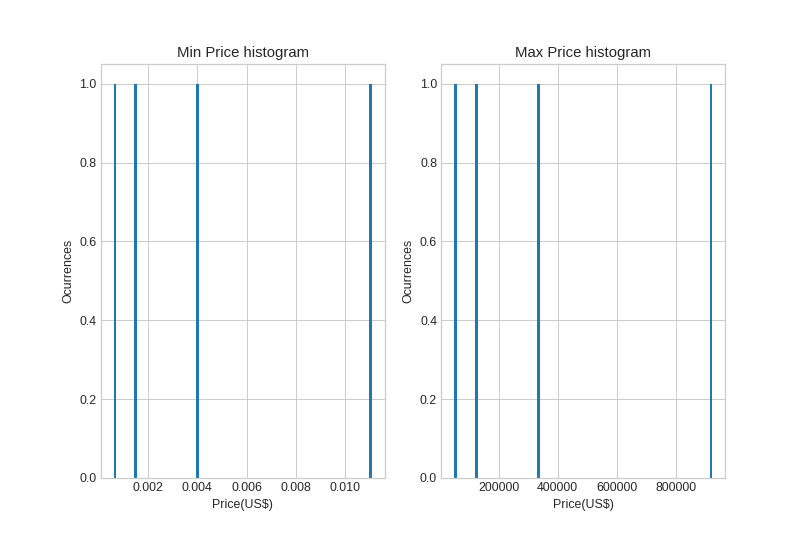

In [12]:
# Plots setup
plt.style.use('seaborn-whitegrid')
fig, [min_plot_ax, max_plot_ax]  = plt.subplots(1, 2, figsize=(9, 6))

def update(
    weight_coeff,
    min_market_cap,
    max_market_cap,
    issuance, 
    length_coeff,
    watch_extrinsic
):
    # Clean the plots
    max_plot_ax.cla()
    min_plot_ax.cla()
    
    # Re-draw labels and titles
    min_plot_ax.set_title("Min Price histogram")
    min_plot_ax.set_xlabel("Price(US$)")
    min_plot_ax.set_ylabel("Ocurrences")
    
    max_plot_ax.set_title("Max Price histogram")
    max_plot_ax.set_xlabel("Price(US$)")
    max_plot_ax.set_ylabel("Ocurrences")

    
    watch_extrinsic_weight = calc_weight(weights[watch_extrinsic], watch_extrinsic, PARAMS)
       
    print(
        watch_extrinsic,
        "min price: ",
        calc_total_price(watch_extrinsic, weight_coeff, min_market_cap, issuance, length_coeff) / 100,
        "US$"
    )
    
    print(
        watch_extrinsic,
        "max price: ",
        calc_total_price(watch_extrinsic, weight_coeff, max_market_cap, issuance, length_coeff) / 100,
        "US$"
    )
    
    attack_cost_widget.value = calc_attack_cost(
        length_coeff, 
        min_market_cap, 
        issuance
    )
    
    df, min_prices, max_prices = calc_all_price(
        weight_coeff, 
        issuance, 
        length_coeff, 
        min_market_cap, 
        max_market_cap
    )
    
    # Display prices histogram
    # Note: we remove the max value because it hides any relevant statistics
    min_prices_hist = min_prices.copy()
    min_prices_hist.remove(max(min_prices_hist))
    min_plot_ax.hist(min_prices_hist, bins=100)
    
    max_prices_hist = max_prices.copy()
    max_prices_hist.remove(max(max_prices_hist))
    max_plot_ax.hist(max_prices_hist, bins=100)
        
    # Display weights for all extrinsics
    display(df.style.hide_index())

# Widgets layout
    
w = interactive(
    update,
    weight_coeff=weight_coeff_widget,
    min_market_cap=min_market_cap_widget,
    max_market_cap=max_market_cap_widget,
    issuance=issuance_widget, 
    length_coeff=length_coefficient_widget,
    watch_extrinsic=watch_extrinsic_widget
)

w.update()

def attack_cost_change_handler(change):
    if (abs(change.new - change.old) > 0.5):
        new_length_coeff = calc_length_coeff(
            int(change.new),
            min_market_cap_widget.value, 
            issuance_widget.value
        )
        if (abs(new_length_coeff - length_coefficient_widget.value) > 1):
            length_coefficient_widget.value = new_length_coeff

attack_cost_widget.observe(attack_cost_change_handler, names='value')

VBox(
    [HBox([c for c in w.children[0:3]]),
     HBox([c for c in w.children[3:5]]), 
     w.children[5], attack_cost_widget, 
     w.children[-1]]
)


# Specific extrinsic examination

This section is reserved to explore the implication of different values for specific extrinsics after viewing the general trend in the dashboard abover.

There is an example how to use it with `forum::add_post`, you just need to call `show_dashboard(extrinsic_name, params, lengths)` with:
* `extrinsic_name`: The extrinsic name
* `params`: a dict of `{<param_name>: <param_value>}`
* `lengths`: an int representing the length of the whole extrinsic in bytes

**Note:** To easily carry over the same values from the dashboard the widgets that `shod_dashboard` uses are the same as the one in the general dashboard, the values will therefore be the same.

In [13]:
EXTRINSIC_NAME = "forum::add_post"

j = 20
post = """
    Lorem ipsum dolor sit amet, consectetur adipiscing elit. 
    Sed sed lacus tellus. In est est, fermentum sed venenatis et, rutrum elementum ex. 
    Nunc felis elit, vestibulum id nisl non, egestas porttitor ex. Quisque vel sagittis ligula. 
    Sed consectetur pharetra mi, non luctus i cursus vitae. Morbi a ipsum at orci finibus.
    """
i = len(post)

parameters = {
    "j": j,
    "i": i,
}

base_encoding_length = 20
length = i + base_encoding_length
    
show_dashboard(EXTRINSIC_NAME, parameters, length)

interactive(children=(FloatText(value=1e-05, description='Weight Coefficient', layout=Layout(max_width='500px'…